In [1]:
from tqdm.notebook import tqdm
import numpy as np
import sys
sys.path.append('../')
from partitioning import is_pow_of_two, init_membership_list
# from spawn import start_db_background
from structures import Params, NetworkParams
from client_dynamo import client_get, client_put, client_get_memory
from parallel_runner import run_parallel
from random import randint

import logging
logger = logging.getLogger('dynamo_node')
logger.setLevel(logging.INFO)

START_PORT = 2333
CLIENT_ID = 1

def get_start_port_no_fail(randomize=True):
    return START_PORT + randint(0, params.num_proc-1) * int(randomize)

def get_stats(durations):
    if len(durations) == 0:
        return {}
    durations = np.array(durations) # convert from seconds to ms
    mean = np.mean(durations)
    std = np.std(durations)
    nnth = np.percentile(durations, 99.9)
    return {'mean': mean, 'std': std, '99.9th': nnth}

def generate_plot(durations, label='', clear=True):
    if clear:
        plt.clf()
    fig = sns.distplot(durations, label=label)
    plt.ylabel('Density')
    plt.xlabel('Response Time (in ms)')
    plt.title('Distribution of response times (in ms)')
    plt.legend()
    plt.show()


In [2]:
params = Params({
    'num_proc' : 8,
    'hash_size': 8, # 2^3 = 8 
    'Q' : 16, # 
    'N' : 4,
    'w_timeout': 2,
    'r_timeout': 2,
    'R': 1,
    'W': 3,
    'gossip': True
})

In [3]:
def run_multiple_get(total, num_requests, get_durations):
    for i in tqdm(range(total // num_requests)):
        requests = [client_get]*num_requests
        requests_params = [{'port': get_start_port_no_fail(), 'client_id': CLIENT_ID, 'key': randint(0, 2**params.hash_size-1)} for _ in range(num_requests)]
        get_durations = np.concatenate((get_durations, run_parallel(requests, requests_params, start_port=START_PORT)))
    return get_durations

def run_multiple_put(total, num_requests, put_durations):
    for i in tqdm(range(total // num_requests)):
        requests = [client_put]*num_requests
        k = randint(0, 2**params.hash_size-1)
        requests_params = [{'port': get_start_port_no_fail(), 'client_id': CLIENT_ID, 'key': k, 'val': str(k)} for _ in range(num_requests)]
        put_durations = np.concatenate((put_durations, run_parallel(requests, requests_params, start_port=START_PORT)))
    return put_durations

def store_keys(params):
    for key in tqdm(range(2**params.hash_size)):
        client_put(get_start_port_no_fail(), CLIENT_ID, key=key, val=str(key))

In [4]:
# store_keys(params)

## With failures

In [5]:
import logging
logger = logging.getLogger('dynamo_node')
logger.setLevel(logging.INFO)
# logger.propagate = False

In [6]:
def get_start_port(randomize=True, failed_ports=None):
    new_port = START_PORT + randint(0, params.num_proc-1) * int(randomize)
    while failed_ports is not None and new_port in failed_ports:
        new_port = START_PORT + randint(0, params.num_proc-1) * int(randomize)
    return new_port

def run_multiple_get(total, num_requests, get_durations=None, failed_port=None):
    durations, responses = [], []
    for i in tqdm(range(total // num_requests)):
        requests = [client_get]*num_requests
        key = randint(0, 2**params.hash_size-1)
#         while (key >= 176 and key <= 191) or (key >= 208 and key <= 223):
#             # dont want a key to go to a failed coordinator node
#             key = randint(0, 2**params.hash_size-1)                             
        requests_params = [{'port': get_start_port(failed_port=failed_port), 'client_id': CLIENT_ID, 'key': key} for _ in range(num_requests)]
        _durations, _responses = run_parallel(requests, requests_params, start_port=START_PORT, as_np=False)
        print(len(_durations))
        durations.extend(_durations)
        responses.extend(_responses)
    return durations, responses

In [7]:
from client_dynamo import client_fail
import random
import time

def wreak_havoc(failed_ports):
    '''
    returns updated list of failing nodes
    '''
    # bring some failed nodes back online
    
    # fail some other nodes randomly
    ports_to_unfail = []
    if failed_ports != None and len(failed_ports) >3:
        ports_to_unfail = failed_ports[:3]
        failed_ports = failed_ports[4:]
    
    for n in ports_to_unfail:
        client_fail(n, fail=False)
        
    new_candidate_for_failure = get_start_port(failed_ports=failed_ports)
    
    client_fail(new_candidate_for_failure, fail=True)
    
    if failed_ports == None:
        failed_ports = [new_candidate_for_failure]
    else:
        failed_ports.append(new_candidate_for_failure)
    
    return failed_ports
    
    
import random
def random_get_put_requests(keys_in_db={}, failed_ports=None):
    '''
    Make 100 random get or put requests
    '''
    durations = []
    for i in tqdm(range(1000)):
#         time.sleep(random.uniform(0.4, 0.6))
        try:
            p = random.uniform(0,1)

            if p >= 0.5 and keys_in_db != {}:
                key = randint(0, 2**params.hash_size-1)

                while key not in keys_in_db:
                    key = randint(0, 2**params.hash_size-1)

                s = time.time()
                port_to_send = get_start_port(failed_ports=failed_ports)
#                 print(f"GET port={port_to_send}, key={key}")
                response = client_get(port=port_to_send, client_id=CLIENT_ID, key=key)
                e = time.time()
                if response.succ == False:
                    print("GET didn't succeed")
                    durations.append(("get_failed", e - s))
                    continue
                # TODO: see if any versions diverge ?

                
                durations.append(("get", e - s))
            else:
                # send 1 put request
                key = randint(0, 2**params.hash_size-1)
                val = str(key)
                context = None
                if key in keys_in_db:
                    # use the vector clock returned by that key
                    try:
                        context = keys_in_db[key].context
                    except:
                        print(keys_in_db[key])
                        raise NotImplementedError
                s = time.time()
                port_to_send = get_start_port(failed_ports=failed_ports)
#                 print(f"PUT port={port_to_send}, key={key}, val={val}")
                response = client_put(port=port_to_send, client_id=CLIENT_ID, key=key, val=val, context=context)
                e = time.time()
                if response.succ == False:
                    print("PUT didn't succeed")
                    durations.append(("put_failed", e - s))
                    continue
                durations.append(("put", e - s))
                keys_in_db[key] = response
        except:
            pass
            
    return keys_in_db, durations


failed_ports = None
keys_in_db = {}
states = []

for i in range(10):
    # do runs 10 times with different configurations of failing nodes
    keys_in_db, durations = random_get_put_requests(keys_in_db, failed_ports)
    states.append({'failed_ports': failed_ports, 'durations': durations })
    failed_ports = wreak_havoc(failed_ports)
    print(failed_ports)


[2337]



[2337, 2336]



[2337, 2336, 2335]



[2337, 2336, 2335, 2338]



[2336]



[2336, 2338]



[2336, 2338, 2333]



[2336, 2338, 2333, 2335]



[2338]



[2338, 2340]


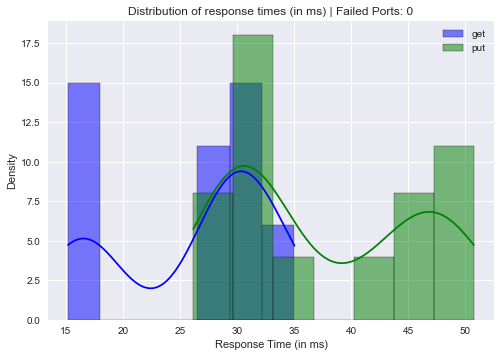

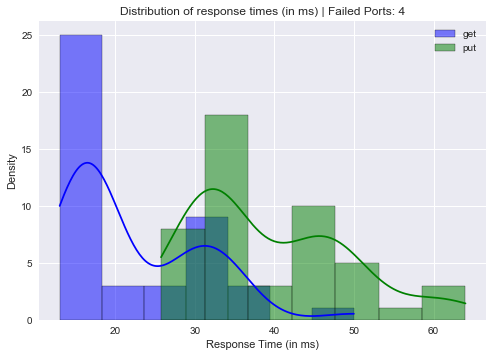

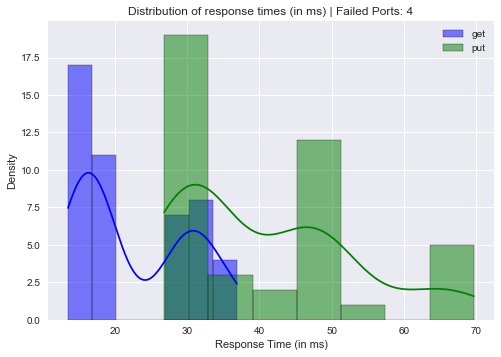

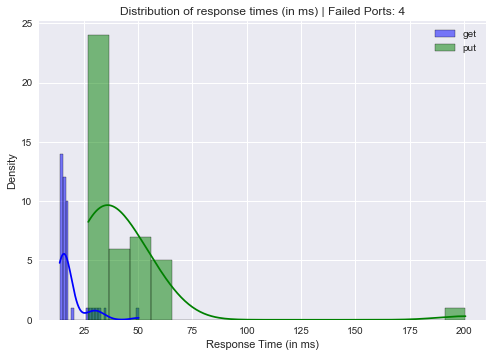

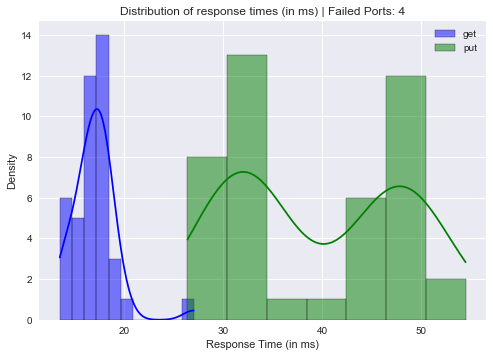

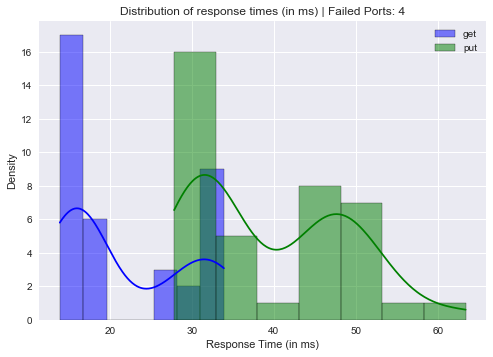

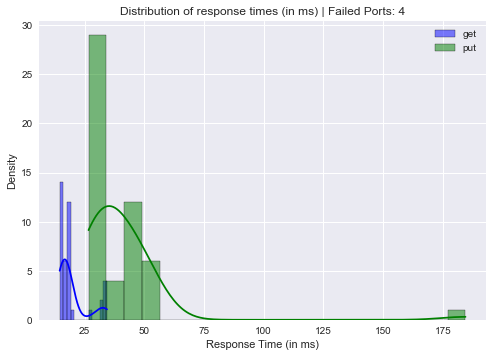

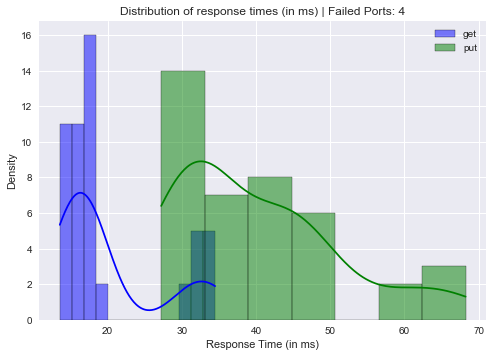

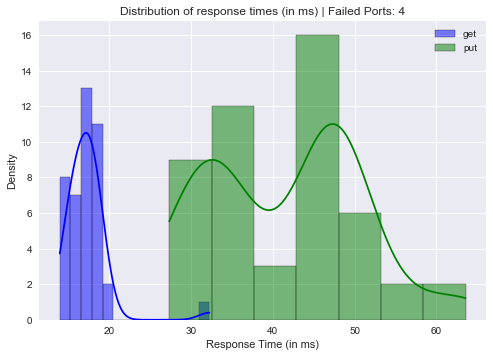

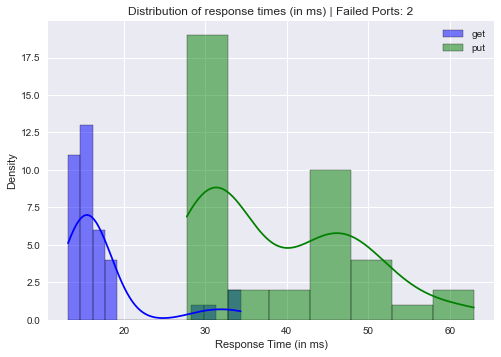

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

def plot_graph(durations, num_failed_ports):
    
    
    def generate_plot(durations, color, label='', clear=True, ax=None):
        if clear:
            plt.clf()
        ax = sns.histplot(durations, label=label, color=color, kde=True, ax=ax)
        return ax
    get_durations = []
    put_durations = []
    put_fail_durations = []
    get_fail_durations = []
    
    for d_type, t in durations:
        if d_type == "get":
            get_durations.append(t*1000)
        elif d_type == "put":
            put_durations.append(t*1000)
        elif d_type == "put_failed":
            put_fail_durations.append(t*1000)
        elif d_type == "get_failed":
            get_fail_durations.append(t*1000)
    
    get_durations = np.asarray(get_durations)
    put_durations = np.asarray(put_durations)
    get_fail_durations = np.asarray(get_fail_durations)
    put_fail_durations = np.asarray(put_fail_durations)
    
    ax = generate_plot(get_durations, color='blue', label="get", clear=True)
    ax = generate_plot(put_durations, color='green', label="put", clear=False, ax=ax)
    ax = generate_plot(get_fail_durations, color='red', label="get_failed", clear=False, ax=ax)
    ax = generate_plot(put_fail_durations, color='yellow',label="put_failed", clear=False, ax=ax)
    
    plt.ylabel('Density')
    plt.xlabel('Response Time (in ms)')
    plt.title(f'Distribution of response times (in ms) | Failed Ports: {num_failed_ports}')
    plt.legend()
    plt.show()

for i in range(10):
    if states[i]['failed_ports'] == None:
        num_failed_ports = 0
    else:
        num_failed_ports = len(states[i]['failed_ports'])
    plot_graph(states[i]['durations'], num_failed_ports=num_failed_ports)

In [ ]:
mem1, replic_mem = client_get_memory(2340)

keys = []
for k,v in mem1.items():
    keys.append(k)

k1 = sorted(keys)
for k in k1:
    print(k)

keys = []
for _,v in replic_mem.items():
    for k,v in v.mem.items():
        keys.append(k)

k2 = sorted(keys)
for k in k2:
    print(k)

In [ ]:
client_fail(START_PORT, fail=True)

In [ ]:
response = client_put(START_PORT+1, CLIENT_ID, 0, "0")
print(response)

response = client_get(START_PORT+1, CLIENT_ID, 0)
print(response)

In [ ]:
# get_fail_durations = np.array([])
get_fail_durations, responses = run_multiple_get(30, 10, None, START_PORT)

In [ ]:
get_fail_durations = np.array(get_fail_durations)

get_fail_durations.shape

In [ ]:
len(get_fail_durations)

In [ ]:
get_fail_durations*1000

In [ ]:
responses

In [ ]:
get_durations.shape

In [ ]:
test = [0.029925823211669922, 0.03148627281188965, 0.031996965408325195, 0.03176593780517578, 0.031462907791137695, 0.030453920364379883, 0.03252911567687988, 0.0177609920501709, 0.1620798110961914, 0.2121727466583252, 0.22617697715759277, 0.2506279945373535, 0.24697089195251465, 0.29291319847106934, 0.4482302665710449, 0.40848278999328613, 0.48263120651245117]

In [ ]:
len(test)